In [1]:
from src.pipeline.auto_encoder import AutoEncoder, get_normal_train_data
from tensorflow.keras.layers import Dense, Input, Dropout

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from src.utils.rw_utils import read_from_csv
import warnings

warnings.filterwarnings(action='ignore')

2022-01-04 00:48:25.104363: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 00:48:25.104405: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# resource: https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea

In [3]:
data = read_from_csv("preprocessed.csv")
data.head()

Data is read. Len of the data 283726 and columns Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
label_column_name = "Class"
x, y = data.drop([label_column_name], axis=1), data[[label_column_name]]

In [5]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
# scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
train_fraud, train_normal = get_normal_train_data(x_train, y_train)

In [8]:
test_fraud, test_normal = get_normal_train_data(x_test, y_test)

In [9]:
# sadece örnek sayısı fazla olan sınıfı kullanalım
nb_epoch = 50
batch_size = 64
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
input_dim = x_train.shape[1]
learning_rate = 1e-7

In [10]:
encoder_layers = [Dense(units=encoding_dim, input_dim = input_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate)),
                  Dropout(0.2),
                  Dense(hidden_dim_1, activation='relu'),
                  Dense(hidden_dim_2, activation=tf.nn.leaky_relu)]
decoder_layers = [Dense(hidden_dim_1, activation='relu'),
                  Dropout(0.2),
                  Dense(encoding_dim, activation='relu'), 
                  Dense(input_dim, activation='tanh')]

In [11]:
model = AutoEncoder(encoder_layers=encoder_layers, decoder_layers=decoder_layers)

2022-01-04 00:48:31.723282: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-04 00:48:31.729261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-04 00:48:31.742033: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-04 00:48:31.742053: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (havvanur-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-04 00:48:31.744367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 00

In [12]:
model.compile(metrics=['accuracy'],
              loss='mean_squared_error',
              optimizer='adam')

In [13]:
history =  model.fit(train_normal, train_normal,
                      epochs=nb_epoch,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_data=(x_test, x_test),
                      verbose=1).history

2022-01-04 00:48:34.136492: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27191640 exceeds 10% of free system memory.
2022-01-04 00:48:34.166266: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27191640 exceeds 10% of free system memory.
2022-01-04 00:48:34.215896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-04 00:48:34.221392: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2303995000 Hz


Epoch 1/50
3541/3541 [==============================] - 6s 2ms/step - loss: 0.8750 - accuracy: 0.1239 - val_loss: 0.7913 - val_accuracy: 0.1714
Epoch 2/50
3541/3541 [==============================] - 5s 1ms/step - loss: 0.8029 - accuracy: 0.1642 - val_loss: 0.7794 - val_accuracy: 0.1794
Epoch 3/50
3541/3541 [==============================] - 5s 1ms/step - loss: 0.8140 - accuracy: 0.1768 - val_loss: 0.7671 - val_accuracy: 0.1930
Epoch 4/50
3541/3541 [==============================] - 5s 1ms/step - loss: 0.7847 - accuracy: 0.1862 - val_loss: 0.7591 - val_accuracy: 0.2107
Epoch 5/50
3541/3541 [==============================] - 6s 2ms/step - loss: 0.7732 - accuracy: 0.1900 - val_loss: 0.7530 - val_accuracy: 0.1938
Epoch 6/50
3541/3541 [==============================] - 5s 2ms/step - loss: 0.7871 - accuracy: 0.1904 - val_loss: 0.7499 - val_accuracy: 0.2220
Epoch 7/50
3541/3541 [==============================] - 6s 2ms/step - loss: 0.7745 - accuracy: 0.2006 - val_loss: 0.7494 - val_accuracy:

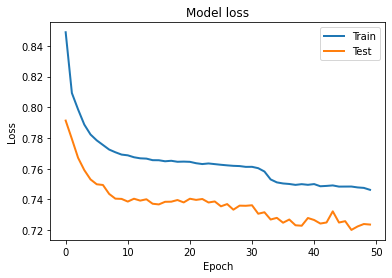

In [14]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [15]:
test_x_predictions = model.predict(x_test)
mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.values.reshape(-1)})
error_df

,Reconstruction_error,True_class
0,0.429322,0
1,2.048392,0
2,0.625730,0
3,0.273028,0
4,1.094484,0
...,...,...
56741,1.152809,0
56742,0.353683,0
56743,0.330399,0
56744,0.587194,0


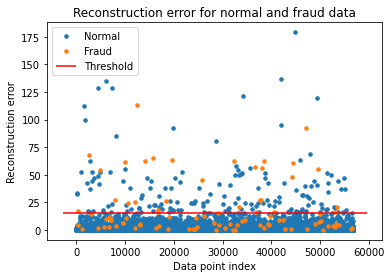

In [24]:
threshold_fixed = 15
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

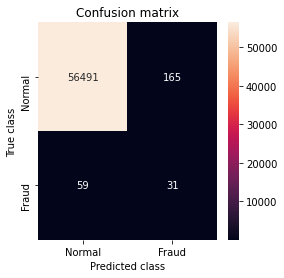

 Accuracy:  0.9960525852042434
 Recall:  0.34444444444444444
 Precision:  0.15816326530612246


In [25]:
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))